# Assignment 2
## Advanced Financial Economics M-335

#### An Exercise of Financial Crises Prediction Using Machine Learning Techniques.

This assignment is inspired by the research article *'Credit growth, the yield curve and financial
crisis prediction: evidence from a machine
learning approach'* (2019), by Bluwstein et al. The idea is to reproduce the financial crises prediction exercise in that paper on a smaller scale.

Our prediction exercise takes the form of a binary classification problem, where each datapoint characterized by a vector of predictors $\textbf{x}_t=(x^1_t, x^2_t,\dots,x^N_t)$ realized at time $t$ must be classified into one of two categories: 1) there **will** be a financial crises **at time *t+1 or t+2***. 2) there **will not** be a financial crises **at time *t+1 or t+2***. Time *t* is measured in years. Your task is to implement this prediction problem using five machine learning algorithms:
 1. logistic regression
 2. logistic regression with LASSO regularization
 3. random trees
 4. random forest
 5. neural networks. 
   
Your task is to assess the accuracy of each and make all the performance comparisons you deem appropriate from what we have learned in class.

I will walk you through the beginning of this exercise, basically importing and cleaning the data. Then I'll leave you to the rest...

To get started, open the Jupyter Notebook where you will execute your assignment.


##### 1. Import the Python modules you need
First import the modules you need (you will certainly need to import more later on, `matplotlib` or `seaborn` for plotting, `sklearn` indeed. By the way, remember to add `%matplotlib inline` to show plots)

In [1]:
import numpy as np
import pandas as pd

##### 2. Load the dataset as a Pandas Data Frame
Import the dataset from the Excel file (located in the same directory as notebook) as a Pandas DataFrame

In [2]:
df=pd.read_excel("JSTdatasetR4.xlsx",sheet_name="Data")

##### 3. Creating the desired variables in a new Data Frame
Now we need to do a few manipulations on the database. Basically we need to create a smaller dataframe comprising only the variables we need, which are those in the *Baseline Experiment* of Bluwstein et al (2019). The code below (with comments) reports how I would do it, but feel free to follow your own method based on your reading of the paper:

In [3]:
df.country.unique()

array(['Australia', 'Belgium', 'Canada', 'Denmark', 'Finland', 'France',
       'Germany', 'Italy', 'Japan', 'Netherlands', 'Norway', 'Portugal',
       'Spain', 'Sweden', 'Switzerland', 'UK', 'USA'], dtype=object)

In [4]:
#let's make a copy, in order to preserve original dataset
df_copy=df.copy()
#let's create new (temporary) columns with the transormed variables we need:
#-slope of the yield curve
df_copy["slope_yield_curve"]=df_copy["ltrate"]/100-df_copy["stir"]/100
# credit: loans to the privete sector / gdp
df_copy["credit"]=df_copy["tloans"]/df_copy["gdp"]
# debt service ratio: credit * long term interest rate
df_copy["debt_serv_ratio"]=(df_copy["tloans"]/df_copy["gdp"])*df_copy["ltrate"]/100
# broad money over gdp
df_copy["bmoney_gdp"]=df_copy["money"]/df_copy["gdp"]
# current account over gdp
df_copy["curr_acc_gdp"]=df_copy["ca"]/df_copy["gdp"]
# Now we need to compute 1-year absolute variations and percentage variations for a few variables
# Obviosly this must be done country-wise, so we cannot act on the dataframe as it is.
# a Convenient way of doing this is the Pandas method 'groupby()'
df_copy_group=df_copy.groupby("iso") # 'iso' is the country code
# create 1 year-variation of credit from grouped dataframe and add back to initial dataframe
df_copy["delta_credit"]=df_copy_group["credit"].diff(periods=1)
# create 1 year-variation of debt ser ratio from grouped dataframe and add back to initial dataframe
df_copy["delta_debt_serv_ratio"]=df_copy_group["debt_serv_ratio"].diff(periods=1)
# create 1 year-variation of investment/gdp from grouped dataframe and add back to initial dataframe
df_copy["delta_investm_ratio"]=df_copy_group["iy"].diff(periods=1)
# create 1 year-variation of public debt/gdp from grouped dataframe and add back to initial dataframe
df_copy["delta_pdebt_ratio"]=df_copy_group["debtgdp"].diff(periods=1)
# create 1 year-variation of broad money / gdp from grouped dataframe and add back to initial dataframe
df_copy["delta_bmoney_gdp"]=df_copy_group["bmoney_gdp"].diff(periods=1)
# create 1 year-variation of current / gdp from grouped dataframe and add back to initial dataframe
df_copy["delta_curr_acc_gdp"]=df_copy_group["curr_acc_gdp"].diff(periods=1)
# now we need to create new variables which are 1-year growth rates of existing ones

# we will need this function to apply to the columns of the dataframe

def lag_pct_change(x):
    """ Computes percentage changes """
    lag = np.array(pd.Series(x).shift(1))
    return (x - lag) / lag

# create 1 year growth rate of CPI from grouped dataframe and add back to initial dataframe
df_copy["growth_cpi"]=df_copy_group["cpi"].apply(lag_pct_change)
# create 1 year growth rate of consumption per capita from grouped dataframe and add back to initial dataframe
df_copy["growth_cons"]=df_copy_group["rconpc"].apply(lag_pct_change)

# low let's create the crises early warning label: a dummy variable which takes value one if in the next 
# or two there will be a crises

# temporary array of zeros, dimension number of rows in database
temp_array=np.zeros(len(df_copy))
# loop to create dummy
for i in np.arange(0,len(df_copy)-2):
    temp_array[i]= 1 if ( (df_copy.loc[i+1,'crisisJST']== 1) or (df_copy.loc[i+2,'crisisJST']== 1)  ) else 0

#put the dummy in the dataframe

df_copy["crisis_warning"]=temp_array.astype("int64")

# create a smaller dataframe including only the variables we are interested in: the first ten are predictors (X) and the last one is the output, or label (y)
variables=["slope_yield_curve","delta_credit","delta_debt_serv_ratio","delta_investm_ratio","delta_pdebt_ratio","delta_bmoney_gdp","delta_curr_acc_gdp","growth_cpi","growth_cons","eq_tr","crisis_warning"]
df_final=df_copy[variables].dropna()

# let's also create a version of our dataframe which includes the year
df_final_withyear=df_copy[["year"]+variables].dropna()

Notice that Bluwstein et al (2019) drop more observations than what I did in order to obtain more robust results. Fill free to follow their procedure more closely. Otherwise, I am fine with `df_final`.

##### 4. Now perform your analysis
Remember that the feature that you need to predict (the outcome $y$) is the variable `df_final["crisis_warning"]`, while all the other columns in the data frame are the features $x$ that you use to predict it.

Inspired by what we have learned from the notebooks `regression.ipynb` and `classification.ipynb`, and possibly your reading of the additional material in the repository, perform your data analysis:

1. Randomly split the data into a training and a test sample.
2. Fit the following models on the training sample:
    * logistic regression
    * logistic regression with LASSO regularization. Here, select the regularization parameter using a 5-fold cross validation
    *  random trees. Experiment with different tree depths, not necessarily with a cross validation
    *  random forest 
    *  neural networks. Experiment with different numbers of hidden layers, and neurons for each layers, not necessarily using a cross-validation
3. Plot the ROC curves for the best versions of your models and compute the AUROC. According to this criterion, which model performs best ?
4. Compare the confusion matrices generated by the models.
5. Which variables do 'survive' in the logistic regression with LASSO ? 
6. OPTIONAL: Is there a way in the logistic regression to conclude which variables are more important for the prediction performance ?
7. OPTIONAL: Now let's see if in a real-time experiment any of our models would have predicted the financial crises of 2007-08. Put all the observations before (and including) 2005 in the training sample, and the rest in the test sample. You can use the data frame `df_final_withyear` for this purpose. Fit your preferred model for each of the 5 categories on the training sample. Would have they warned us in 2006 and 2007 of the imminent financial crises?  (for the logistic regressions, in order to draw this conclusion use the probability thresholds which, on  the ROC curves, obtain an 80\% rate of true positives).
8. OPTIONAL: compute any indicator you like......  


In [5]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Train test split

In [6]:
X = df_final.drop('crisis_warning', axis = 1)
y = df_final.crisis_warning

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# 2. Fitting

## Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(penalty = 'none', max_iter = 1000).fit(X_train, y_train)

## Logistic Regression with Lasso

In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
log_reg_lasso = LogisticRegression(penalty = 'l1', solver = 'liblinear', max_iter = 1000)
parameters = {'C':[1, 10, 100]}
grid_search_results = GridSearchCV(log_reg_lasso, parameters, 'roc_auc').fit(X_train, y_train)

pd.DataFrame(grid_search_results.cv_results_)

/Users/andrey_lukyanov/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003502,0.000564,0.002379,0.000291,1,{'C': 1},0.592961,0.621957,0.665053,0.515789,0.476222,0.574396,0.069135,3
1,0.003260,0.000338,0.002257,0.000256,10,{'C': 10},0.745241,0.724436,0.742737,0.632000,0.710444,0.710972,0.041477,2
2,0.003777,0.000620,0.002581,0.000309,100,{'C': 100},0.739486,0.744135,0.760421,0.680421,0.738000,0.732493,0.027226,1


In [30]:
best_log_reg_lasso = LogisticRegression(penalty = 'l1', C = 100, 
                                        solver = 'liblinear', max_iter = 1000).fit(X_train, y_train)

## Decision Trees

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [12]:
decision_tree = DecisionTreeClassifier().fit(X_train, y_train)
parameters = {'max_depth':[4, 6, 10, 12]}
grid_search_results = GridSearchCV(decision_tree, parameters, 'roc_auc').fit(X_train, y_train)

pd.DataFrame(grid_search_results.cv_results_)

/Users/andrey_lukyanov/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005756,0.000268,0.002489,0.000081,4,{'max_depth': 4},0.626937,0.646525,0.629263,0.736947,0.722222,0.672379,0.047425,1
1,0.009501,0.002468,0.003997,0.001420,6,{'max_depth': 6},0.713037,0.653165,0.709895,0.604842,0.561556,0.648499,0.059028,2
2,0.008036,0.000440,0.002259,0.000157,10,{'max_depth': 10},0.659805,0.558101,0.717579,0.631789,0.500889,0.613633,0.076238,3
3,0.008261,0.000497,0.002208,0.000083,12,{'max_depth': 12},0.601815,0.562749,0.733895,0.528526,0.552333,0.595864,0.072957,4


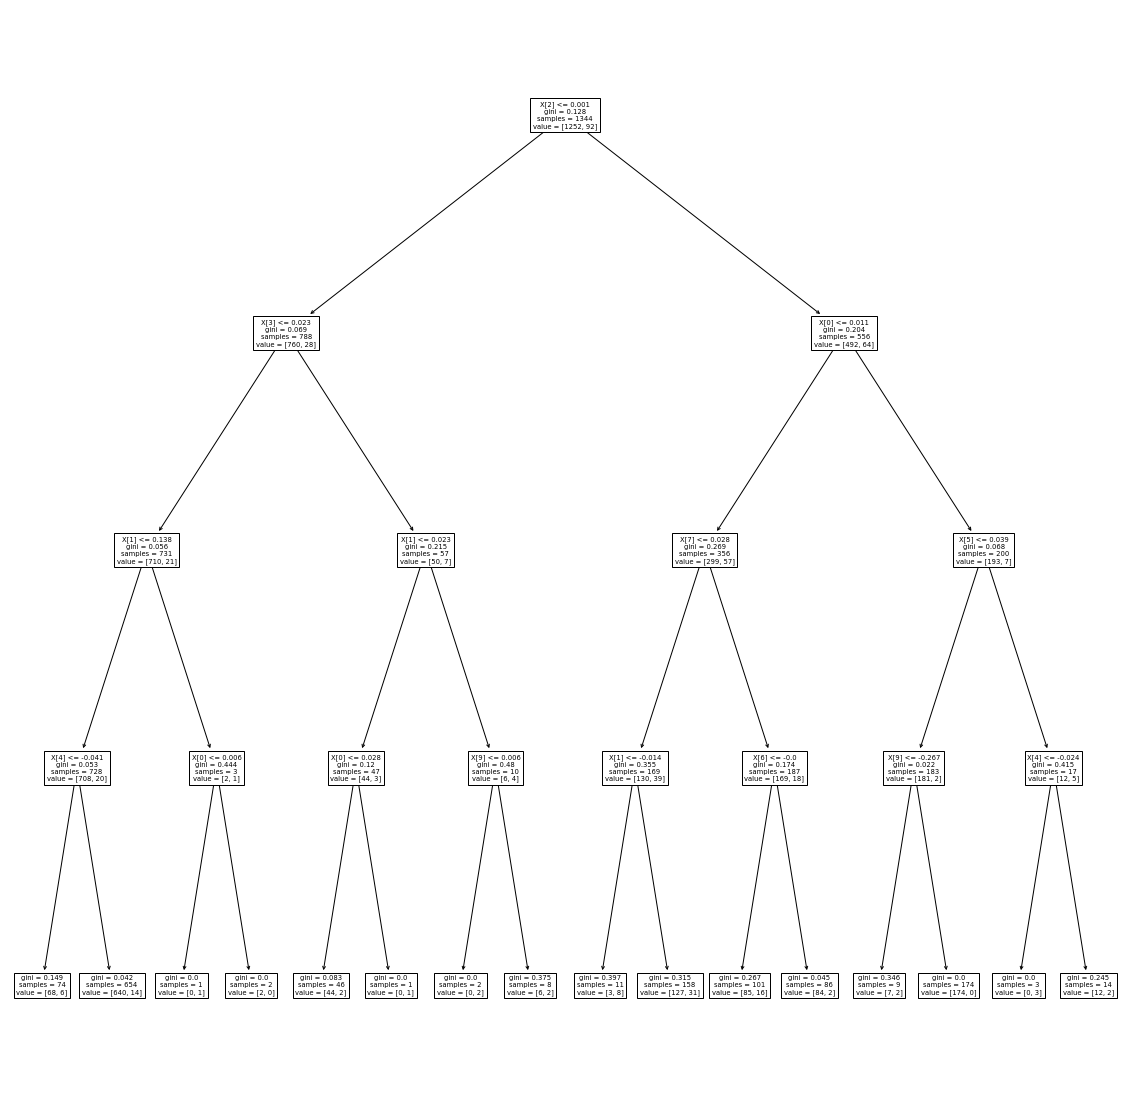

In [13]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20))
best_decision_tree = DecisionTreeClassifier(max_depth = 4).fit(X_train, y_train)

tree.plot_tree(best_decision_tree);

## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier().fit(X_train, y_train)

## Neural Networks

In [15]:
from sklearn.neural_network import MLPClassifier

In [16]:
nn = MLPClassifier(solver='lbfgs', random_state=1, max_iter = 10000)
parameters = {'hidden_layer_sizes':[(10), (20), (10, 15), (20, 25)]}

grid_search_results = GridSearchCV(nn, parameters, 'roc_auc').fit(X_train, y_train)

pd.DataFrame(grid_search_results.cv_results_)

/Users/andrey_lukyanov/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.299053,0.186894,0.002602,0.000128,10,{'hidden_layer_sizes': 10},0.718017,0.729969,0.650316,0.614737,0.737556,0.690119,0.048751,1
1,1.477202,1.030927,0.003271,0.000964,20,{'hidden_layer_sizes': 20},0.755865,0.711598,0.567789,0.563789,0.563333,0.632475,0.083867,3
2,1.838674,1.172761,0.002628,0.000169,"(10, 15)","{'hidden_layer_sizes': (10, 15)}",0.718459,0.708057,0.523158,0.580421,0.592667,0.624552,0.076206,4
3,2.672619,1.236046,0.002528,0.000073,"(20, 25)","{'hidden_layer_sizes': (20, 25)}",0.669101,0.810536,0.538316,0.581895,0.681778,0.656325,0.093870,2


In [17]:
best_nn = MLPClassifier(solver='lbfgs', hidden_layer_sizes = (10), 
                        random_state=1, max_iter = 10000).fit(X_train, y_train)

## Gradient Boosting

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

In [19]:
GBC = GradientBoostingClassifier().fit(X_train, y_train)

# 3. AUC ROC

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [21]:
models = {'Logistic Regression': log_reg, 
          'Logistic Regression L1': best_log_reg_lasso, 
          'Decision Tree': best_decision_tree,
          'Random Forest': random_forest, 
          'Neural Network': best_nn,
          'Gradient Boosting': GBC}

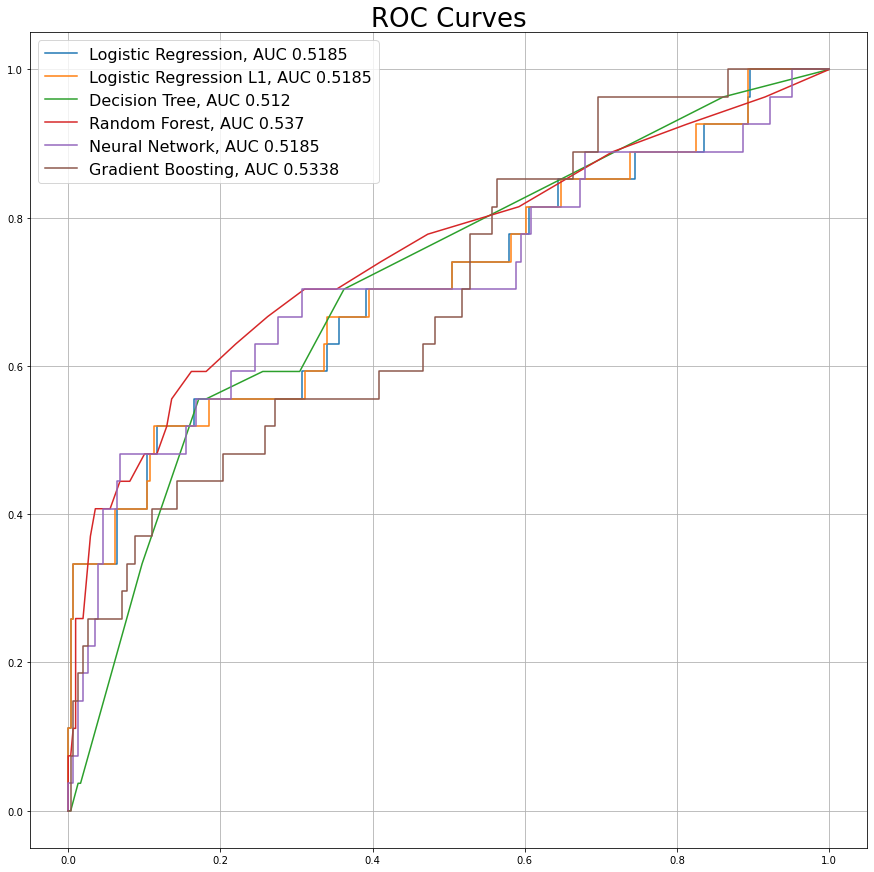

In [22]:
plt.figure(figsize = (15, 15))
plt.title('ROC Curves', fontsize = 26)
plt.grid()

for model in models: 
    fpr, tpr, _ = roc_curve(y_test, models[model].predict_proba(X_test)[:,1])
    auc = round(roc_auc_score(y_test, models[model].predict(X_test)), 4)
    plt.plot(fpr, tpr, label = model + ', AUC ' + str(auc))
    
plt.legend(fontsize = 16);

Gradient Boosting performs best, but not by a huge margin.

# 4. Confusion matricies

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
for model in models: 
    print(model)
    print(pd.DataFrame(confusion_matrix(y_test, models[model].predict(X_test))))
    print()

Logistic Regression
     0  1
0  309  0
1   26  1

Logistic Regression L1
     0  1
0  309  0
1   26  1

Decision Tree
     0  1
0  305  4
1   26  1

Random Forest
     0  1
0  309  0
1   25  2

Neural Network
     0  1
0  309  0
1   26  1

Gradient Boosting
     0  1
0  307  2
1   25  2



On the main diagonal of the tables these are true negatives and true positives, while on the secondary false negatives and false positives. In general, the results are not much different from each other. However, what all of them have in comon is the relatively high number of False Negatives and low of True Positives. 

# 5. Which factors survived?

In [31]:
best_log_reg_lasso.coef_

array([[-25.33069052,   6.7746019 ,  61.35966738,  15.06073418,
         -3.80406442,   0.70179737,  -4.82827478,  -5.79567101,
         -6.10469024,   0.21006442]])

All.

# 6. Relative importance of variables in a logistic regression

https://stats.stackexchange.com/questions/295146/relative-importance-of-predictors-in-logistic-regression

# 7. Prediction

In [26]:
X_before_2005 = df_final_withyear[df_final_withyear.year < 2005].drop(['year', 'crisis_warning'], axis = 1)
y_before_2005 = df_final_withyear[df_final_withyear.year < 2005].crisis_warning

X_after_2005 = df_final_withyear[(df_final_withyear.year == 2006) | (df_final_withyear.year == 2007)].drop(['year', 'crisis_warning'], axis = 1)
y_after_2005 = df_final_withyear[(df_final_withyear.year == 2006) | (df_final_withyear.year == 2007)].crisis_warning

In [27]:
predictions = pd.DataFrame(np.zeros([32, 6]), columns = models.keys())

for model in models:
    model_fit = models[model].fit(X_before_2005, y_before_2005)
    if 'Logistic Regression' in model:
        predictions[model] = (model_fit.predict_proba(X_after_2005)[:,1] >= 0.8) * 1
    else:
        predictions[model] = model_fit.predict(X_after_2005)

predictions['True Value'] = y_after_2005.values
predictions

,Logistic Regression,Logistic Regression L1,Decision Tree,Random Forest,Neural Network,Gradient Boosting,True Value
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,1,0,0,0,1
5,0,0,0,0,0,1,1
6,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1
9,0,0,0,0,0,0,1


Well, this is a failure.